# Timing malaria transmission with mosquito fluctuations
## Daily fluctuations in parasitaemia

This analysis explores the frequency content of parasitaemia signals. Gaussian processes are used to detrend these signals, and then periodograms are estimated using the Lomb-Scargle method.

### Importing the data

First, we import the necessary packages.

In [21]:
# Data manipulation
import numpy as np
import pandas as pd

# Detrending and spectral analysis
from sklearn.gaussian_process import GaussianProcessRegressor
from astroML.time_series import lomb_scargle, lomb_scargle_bootstrap

# Optimisation
import lmfit

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
C = sns.color_palette("deep", 8)

Now, we read in the data measuring parasitaemia three times for each bird. We only keep 

In [17]:
# Read in the raw data
data = pd.read_csv("data/repeat_data.csv")

# Rename a few columns for clarity
data.rename(columns={
    "oiseaux": "bird",
    "Parasitemia1": "P1",
    "Parasitemia2": "P2",
    "Parasitemia3": "P3",
    "traitement": "experiment",
    "heure2": "time"
}, inplace=True)

# Keep only control birds and reindex by bird
data = data[data.bird.isin(["R0323", "R0332", "R0337", "R0350"])]
data.index = data.bird
data = data.sort_values(["bird", "time"])

# Calculate mean and stdev for parasitaemia, per bird, per timestep
data["mean_P"] = data[["P1", "P2", "P3"]].mean(1)
data["std_P"] = data[["P1", "P2", "P3"]].std(1)

# Drop unneeded columns
data = data[["time", "P1", "P2", "P3", "mean_P", "std_P"]].dropna()

print("The first few rows look like this :")
data.head()

The first few rows look like this :


,time,P1,P2,P3,mean_P,std_P
bird,,,,,,
R0323,12.25,10.416667,10.246914,9.289980,9.984520,0.607448
R0323,12.50,15.911111,16.040816,15.862069,15.937999,0.092357
R0323,12.75,17.064715,15.937500,16.666667,16.556294,0.571655
R0323,13.00,6.914286,9.545455,7.058824,7.839521,1.479148
R0323,13.25,9.800000,10.911481,9.571429,10.094303,0.716865


### Visualising the time-series

Here, we simply plot the measurements for each of the three measurements at each timepoint as a scatter, and plot the mean value of these measurements as a solid line. The standard error is shown by the fill. Each subplot represents a different bird.

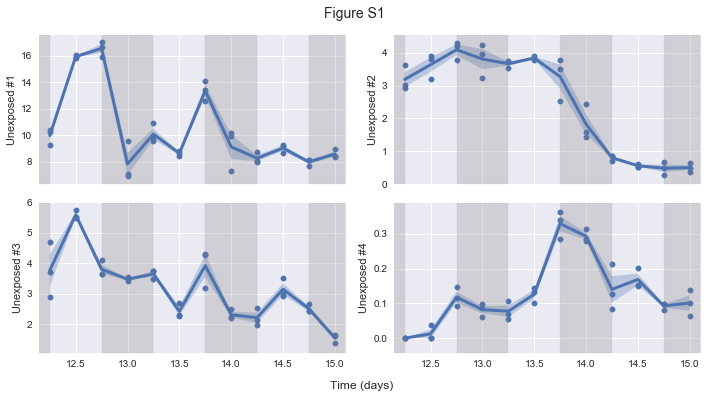

In [24]:
# Set up figure
plt.figure(figsize=(10, 5))
plt.suptitle("Figure S1", fontsize=14, y=1.04)
plt.figtext(0.51, -0.02, "Time (days)", fontsize=12, ha="center")

# For each bird
for i, bird in enumerate(data.index.unique()):

    plt.subplot(2, 2, i+1)
    if i < 2:
        plt.gca().get_xaxis().set_ticklabels([])
    
    # Scatter each parasitaemia measurement
    plt.scatter(np.unique(data.time), data.loc[bird].P1.values, c=C[0], s=30)
    plt.scatter(np.unique(data.time), data.loc[bird].P2.values, c=C[0], s=30)
    plt.scatter(np.unique(data.time), data.loc[bird].P3.values, c=C[0], s=30)
    
    # Plot the mean value as a solid line and the standard error as a fill
    plt.plot(np.unique(data.time), data.loc[bird].mean_P, lw=3, c=C[0])
    plt.fill_between(
        np.unique(data.time), 
        data.loc[bird].mean_P - data.loc[bird].std_P / np.sqrt(3), 
        data.loc[bird].mean_P + data.loc[bird].std_P / np.sqrt(3), 
        alpha=0.3
    )

    # Depict "night time" in grey in the background
    ylim = plt.gca().get_ylim()
    plt.fill_between([11.75, 12.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([12.75, 13.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([13.75, 14.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([14.75, 15.25], *ylim, color="grey", alpha=0.25)
    plt.ylim(*ylim)
    plt.xlim(data.time.min()-0.1, data.time.max()+0.1)
    
    plt.ylabel("Unexposed #{}".format(i+1))

plt.tight_layout()
plt.savefig("fig1.pdf", bbox_inches="tight")

### Detrending the signals

For each bird, we fit a Gaussian process regression to the mean parasitaemia data. We assume that each of the three measurements taken at each timepoint is independent and identically distributed, and that the mean of these measurements therefore represents a closer approximation to the true underlying signal than the individual measurements.

The Gaussian process regression is essentially a smoothed version of the mean parasitaemia time-series. When subtracted from this time-series, the trend ( or slow-changing dynamics ) of the time-series are removed.

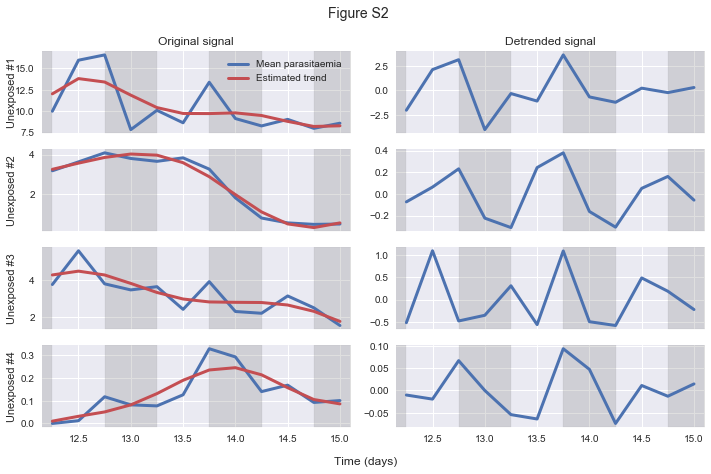

In [40]:
# Dict to save detrended results
detrended = {}

# Set up the figure
plt.figure(figsize=(10, 6))
plt.suptitle("Figure S2", fontsize=14, y=1.04)
plt.figtext(0.51, -0.02, "Time (days)", fontsize=12, ha="center")

# For each bird
for idx, bird in enumerate(data.index.unique()):

    # Pull data in a form sklearn like it
    t = data.loc[bird].time.values[:, np.newaxis]
    y = data.loc[bird].mean_P.values[:, np.newaxis]

    # Define a new Gaussian process regressor, and fit to the data
    gpr = GaussianProcessRegressor(normalize_y=True, alpha=5e-3)
    gpr.fit(t, y)

    # Extract the trend 
    trend = gpr.predict(t).squeeze()
    detrended[bird] = data.loc[bird].mean_P.values - trend

    # On the left, plot the mean in blue, and the trend in red
    plt.subplot(4, 2, 2*idx+1)
    plt.plot(np.unique(data.time), data.loc[bird].mean_P, lw=3, c=C[0])
    plt.plot(np.unique(data.time), trend, lw=3, c=C[2])
    
    # Titles, labels, and night-time
    plt.ylabel("Unexposed #{}".format(idx+1))
    ylim = plt.gca().get_ylim()
    plt.fill_between([11.75, 12.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([12.75, 13.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([13.75, 14.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([14.75, 15.25], *ylim, color="grey", alpha=0.25)
    plt.ylim(*ylim)
    plt.xlim(data.time.min()-0.1, data.time.max()+0.1)
    plt.gca().get_yaxis().set_label_coords(-0.08,0.5)
    
    if idx == 0:
        plt.title("Original signal")
        plt.legend(["Mean parasitaemia", "Estimated trend"])
    if idx < 3:
        plt.gca().get_xaxis().set_ticklabels([])

    # On the right, plot the detrended signals
    plt.subplot(4, 2, 2*idx+2)
    plt.plot(np.unique(data.time), data.loc[bird].mean_P - trend, lw=3)
    ylim = plt.gca().get_ylim()
    plt.fill_between([11.75, 12.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([12.75, 13.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([13.75, 14.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([14.75, 15.25], *ylim, color="grey", alpha=0.25)
    plt.ylim(*ylim)
    plt.xlim(data.time.min()-0.1, data.time.max()+0.1)
    if idx == 0:
        plt.title("Detrended signal")
    if idx < 3:
        plt.gca().get_xaxis().set_ticklabels([])

plt.tight_layout()
plt.savefig("fig2.pdf", bbox_inches="tight")

# Cast detrended signals to dataframe
detrended = pd.DataFrame(detrended, index=data.time.unique())

### Estimating the periodogram

Under the right conditions, time-series signals can be represented exactly in terms of an infinite series of frequency components. The *power spectrum* of a signal represents the distribution of power of the various frequencies that make up the time-series, and is therefore a representation of the signal in terms of frequency, not time. The *periodogram* is an estimate of a signal's power spectrum, and can be computed by a number of methods.

The Lomb-Scargle method is an intuitive technique for computing a signal's periodogram, based on the least-squares fitting of sinusoids to the time-series data. Inputs to the Lomb-Scargle method are the time-series data and the frequencies at which we wish to evaluate the signal's power. The output is then the power spectral estimate at each frequency, as computed by fitting a sinusoid of that frequency to the time-series. Here, we use the `lomb_scargle` method from the `astroML` package.

In [64]:
# Define the frequencies we're interested in :
# from near 0 to 2 per day, with 500 points in between
freqs = np.linspace(0.01, 2, 500)

# Calculate Lomb-Scargle PSD for each bird from detrended signals
psd = {}
significance = {}
for bird in detrended.columns:

    # Calculate periodogram
    psd[bird] = lomb_scargle(detrended.index, detrended[bird], 1, 2 * np.pi * freqs, generalized=True)

    # Bootstrap confidence intervals
    bootstraps = lomb_scargle_bootstrap(t, detrended[bird], 1, 2 * np.pi * freqs, generalized=True, N_bootstraps=1000)

    # Determine significance at the 95% level
    significance[bird] = np.percentile(bootstraps, 95)

# Cast power spectra as a dataframe
psd = pd.DataFrame(psd, index=freqs)

Now that we have our power spectral estimates, we can evaluate whether the presence of a circadian frequency is statistically significant. We now wish to determine the phase of this circadian dynamic, to evaluate at what time of day it peaks.

In [143]:
# Dicts to store results
best_fit_phase = {}
best_fit_amplitude = {}
best_fit_sinusoid = {}
peak_time = {}
peak_time_digital = {}

# For each bird
for bird in detrended.columns:

    # We'll fix the amplitude at one and fit the phase
    phases = np.linspace(-np.pi, np.pi, 1000)
    loss = np.zeros_like(phases)
    for i, phase in enumerate(phases):
        loss[i] = np.sum(np.abs(np.cos(2 * np.pi * t + phase) - detrended[bird])**2)

    # Extract the best-fit phase
    best_fit_phase[bird] = phases[np.argmin(loss)]

    # Determine the hour at which this sinusoid peaks
    t_sin = np.linspace(data.time.unique()[0], data.time.unique()[-1], 500)
    best_fit_sin = np.cos(2 * np.pi * t_sin + best_fit_phase[bird])
    peak = np.argmax(best_fit_sin[:150])
    peak_time_digital[bird] = (t_sin[peak] - 12) * 24
    peak_time[bird] = "{}:{:02.0f}".format(
        int(peak_time_digital[bird]), 
        (peak_time_digital[bird] - int(peak_time_digital[bird])) * 60)

    # For plotting purposes only, let's fit the amplitude.
    amplitudes = np.linspace(0, 3, 1000)
    loss = np.zeros_like(amplitudes)
    for i, amplitude in enumerate(amplitudes):
        loss[i] = np.sum(np.abs(amplitude * np.cos(2 * np.pi * t + best_fit_phase[bird]) - detrended[bird])**2)

    # Extract the best-fit amplitude
    best_fit_amplitude[bird] = amplitudes[np.argmin(loss)]
    
    # Finally, construct the best-fit sinusoid
    best_fit_sinusoid[bird] = best_fit_amplitude[bird] * np.cos(2 * np.pi * t_sin + best_fit_phase[bird])
    
# Cast the sinusoids to dataframe
best_fit_sinusoid = pd.DataFrame(best_fit_sinusoid, index=t_sin)

Let's put the periodograms and the time-series representations together into a figure.

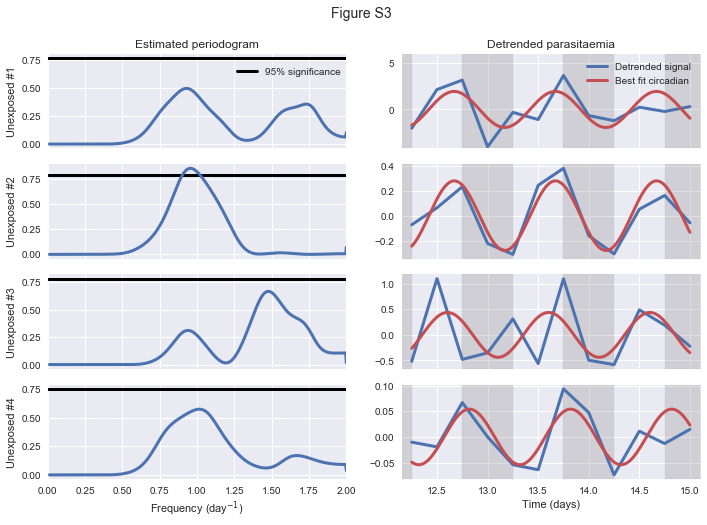

In [144]:
plt.figure(figsize=(10, 7))
plt.suptitle("Figure S3", fontsize=14, y=1.04, x=0.51)

# Each bird gets a row of subplots
for idx, bird in enumerate(np.unique(data.index)):

    # Left-hand column
    plt.subplot(4, 2, 2*idx+1)
    
    # Plot the 95% CI level
    plt.axhline(significance[bird], c="k", lw=3)
    
    # Plot the periodogram
    plt.plot(freqs, psd[bird], lw=3)
    
    # Labels and legends
    plt.ylabel("Unexposed #{}".format(idx+1))
    plt.xlim(0, 2)
    if idx == 0:
        plt.legend(["95% significance"], loc=(0.621, 0.72))
        plt.title("Estimated periodogram")
    if idx == 3:
        plt.xlabel("Frequency (day$^{-1}$)")
    if idx < 3:
        plt.gca().set_xticklabels([])

    # Right-hand column
    plt.subplot(4, 2, 2*idx+2)
    
    # Plot the detrended parasitaemia signals
    plt.plot(detrended[bird], lw=3, c=C[0])
    
    # Plot the best fit sinusoid
    plt.plot(best_fit_sinusoid[bird], c=C[2], lw=3)
    plt.xlim(data.time.min()-0.1, data.time.max()+0.1)
      
    # Labels and legends
    if idx == 0:
        plt.ylim(-4.2, 6)
        plt.legend(["Detrended signal", "Best fit circadian"])
        plt.title("Detrended parasitaemia")
    ylim = plt.gca().get_ylim()
    plt.fill_between([11.75, 12.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([12.75, 13.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([13.75, 14.25], *ylim, color="grey", alpha=0.25)
    plt.fill_between([14.75, 15.25], *ylim, color="grey", alpha=0.25)
    plt.ylim(*ylim)
    if idx == 3:
        plt.xlabel("Time (days)")
    if idx < 3:
        plt.gca().set_xticklabels([])

plt.tight_layout()
plt.savefig("fig3.pdf", bbox_inches="tight")

What are peak times for circadian activity ?

Peak circadian activities occurred at :
- 16:03
- 16:03
- 14:28
- 19:37


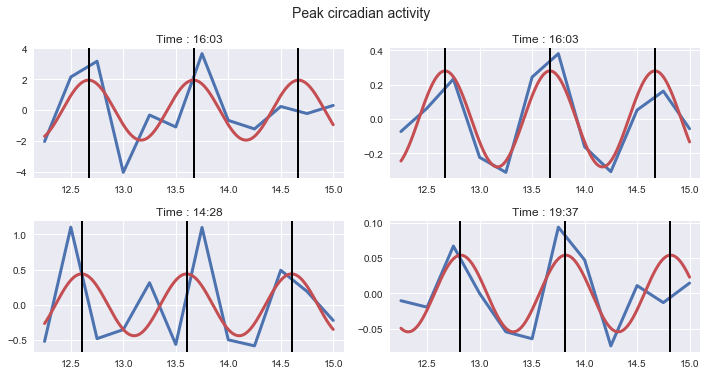

In [145]:
plt.figure(figsize=(10, 5))
plt.suptitle("Peak circadian activity", fontsize=14, y=1.04, x=0.51)
    
for i, bird in enumerate(detrended.columns):
    
    plt.subplot(2, 2, i+1)
    plt.plot(detrended[bird], c=C[0], lw=3)
    
    # Plot the best fit sinusoid
    plt.plot(best_fit_sinusoid[bird], c=C[2], lw=3)
    plt.xlim(data.time.min()-0.1, data.time.max()+0.1)
    
    # Plot the peak time
    plt.axvline(12 + peak_time_digital[bird] / 24, color="k", lw=2)
    plt.axvline(13 + peak_time_digital[bird] / 24, color="k", lw=2)
    plt.axvline(14 + peak_time_digital[bird] / 24, color="k", lw=2)
    
    plt.title("Time : {}".format(peak_time[bird]))
    
plt.tight_layout()

print("Peak circadian activities occurred at :")
for time in peak_time.values():
    print("- {}".format(time))